In [1]:
import torch
import os
import random
import numpy as np
# import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset, load_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 32,
        'rnn_layers': 8,
        'readout_layers': 3,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
# Fix cuda memory issue
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [12:21<00:00,  1.34it/s]


In [3]:
edge_indexes, _, _ = load_classification_dataset(config['dataset'], False)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9547738693467337


# PCA per node

In [19]:
from torch_sparse import SparseTensor

idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

num_nodes = edge_index.max().item() + 1
adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
adj_matrix = adj_matrix.to_dense()

In [20]:
from sklearn.decomposition import PCA
from einops import rearrange

node_states0 = rearrange(node_states[idx], 't n f -> n t f')

pca = PCA(n_components=10)
X = pca.fit_transform(rearrange(node_states0, 'n t f -> (n t) f'))
X = rearrange(X, '(n t) f -> n t f', n=num_nodes, t=node_states0.shape[1], f=10)
X = torch.from_numpy(X)

In [7]:
X.shape

torch.Size([100, 106, 10])

In [8]:
torch.nonzero(adj_matrix).size(0)

210

In [21]:
from DMD.sindy import sindy_library_adj

s = sindy_library_adj(X, adj_matrix)

In [10]:
X.shape

torch.Size([100, 106, 10])

In [23]:
s.shape

torch.Size([410, 106, 10])

In [22]:
from DMD.sindy import sindy_fit2

# s = rearrange(s, 'n t f -> (t n) f', n=s.shape[0], t=s.shape[1], f=10)

x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')

K = sindy_fit2(x, y, 1.0)

In [13]:
K.shape

(1000, 4100)

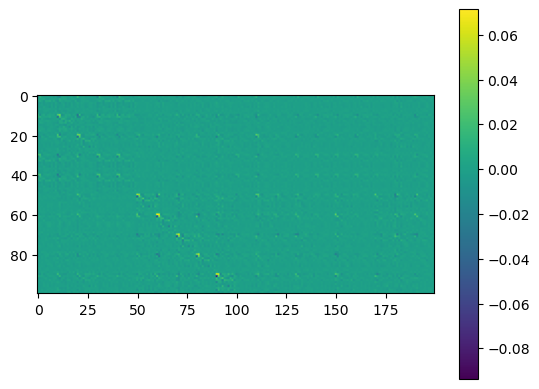

In [23]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(K[:100,:200])
plt.colorbar()
plt.show()

In [ ]:
K.shape

(1000, 4100)

Summing over the "F" dimension

In [24]:
# Reshape K into a 3D array with shape (num_blocks, 10, num_features)
num_blocks = K.shape[0] // 10
sum_K = np.array([np.sum(K[i*10:(i+1)*10], axis=0) for i in range(num_blocks)])

num_blocks = K.shape[1] // 10
sum_K = np.stack([np.sum(sum_K[:,i*10:(i+1)*10], axis=1) for i in range(num_blocks)], axis=1)
# K_reshaped = rearrange(K, '(n f) H -> n f H', n=num_nodes, f=10)

# sum_K = np.sum(K_reshaped, axis=1)

In [16]:
sum_K.shape

(100, 410)

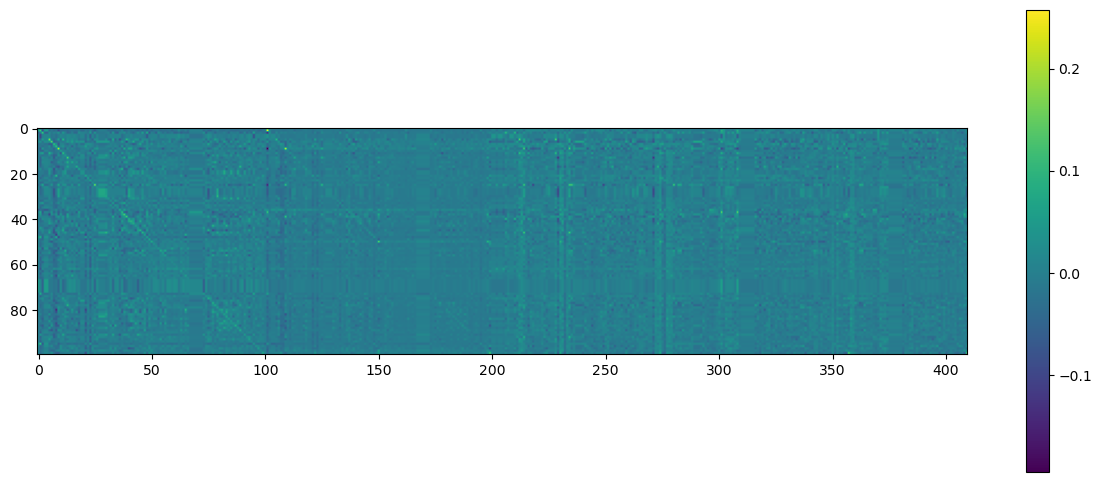

In [25]:
plt.figure(figsize=(15, 6))

plt.imshow(sum_K)
plt.colorbar()
plt.show()

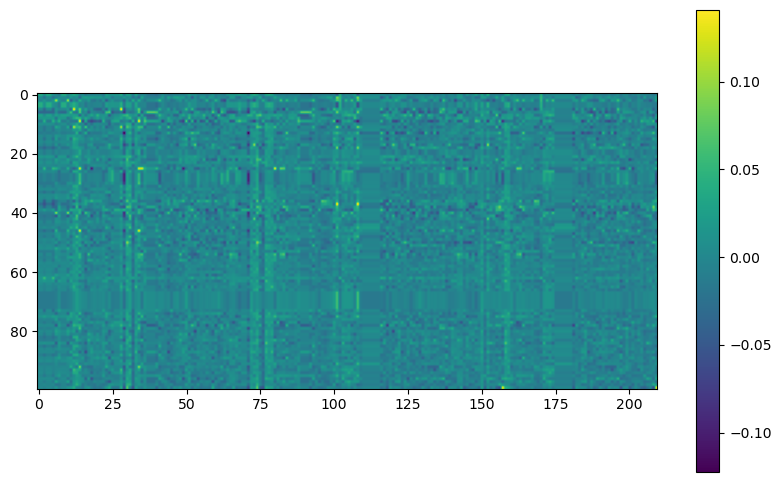

In [26]:
plt.figure(figsize=(10, 6))

plt.imshow(sum_K[:,200:])
plt.colorbar()
plt.show()

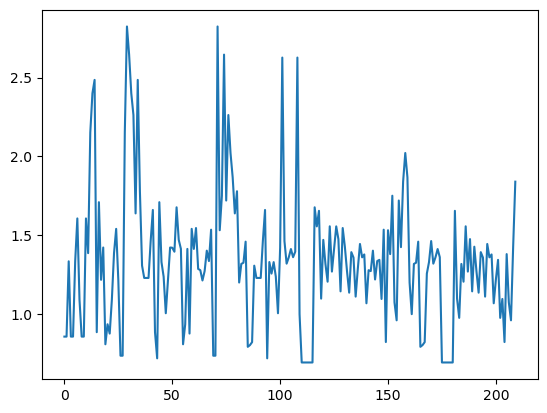

In [27]:
weights = np.abs(sum_K[:,200:]).sum(axis=0)

plt.plot(weights)

In [21]:
idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

In [30]:
node_weights = node_states0[:,-1,:].mean(axis=-1)

/tmp/ipykernel_1039751/2431816995.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)


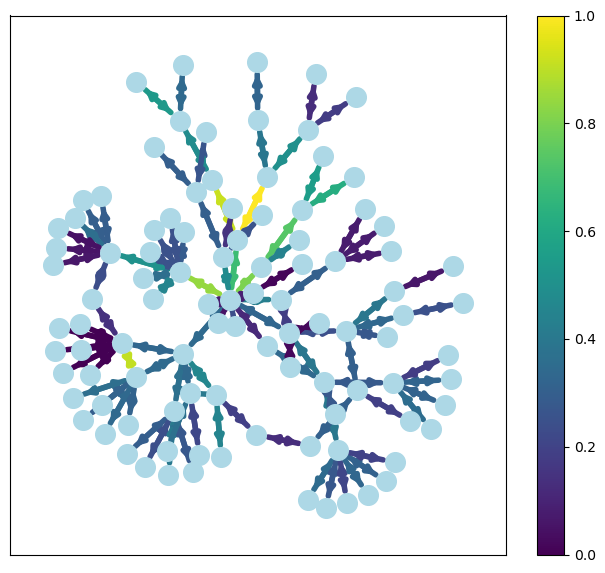

In [34]:
import networkx as nx

import matplotlib.pyplot as plt

# Create an empty graph
plt.figure(figsize=(8, 7))
G = nx.DiGraph()

# Add edges
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')
# norm = plt.Normalize(min(node_weights), max(node_weights))
# colors = [cmap(norm(w)) for w in node_weights]
pax = nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
norm = plt.Normalize(min(weights), max(weights))
colors = [cmap(norm(w)) for w in weights]
# im = nx.draw(G, pos=pos, node_color='lightblue', edge_color=colors, width=2)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
# sm._A = []
plt.colorbar(pax)

# Show the plot
plt.show()

In [5]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")

995it [00:07, 134.29it/s]


In [25]:
nodes_gt0 = nodes_gt[0]

In [41]:
# Create a mask for edge_index
edge_gt = torch.zeros(edge_index.size(1), dtype=torch.int)

# Iterate over each edge in edge_index
for i in range(edge_index.size(1)):
    src, tgt = edge_index[0, i], edge_index[1, i]
    
    # Check if both source and target nodes are in nodes_gt0
    if src in torch.where(nodes_gt0[-1])[0] and tgt in torch.where(nodes_gt0[-1])[0]:
        edge_gt[i] = 1

In [49]:
from sklearn.metrics import roc_auc_score

# Compute the AUC score
# discrete_weights = np.zeros(weights.shape)
# discrete_weights[weights>1.5] = 1
auc_score = roc_auc_score(edge_gt, weights)

print("AUC Score:", auc_score)

AUC Score: 0.8811881188118813


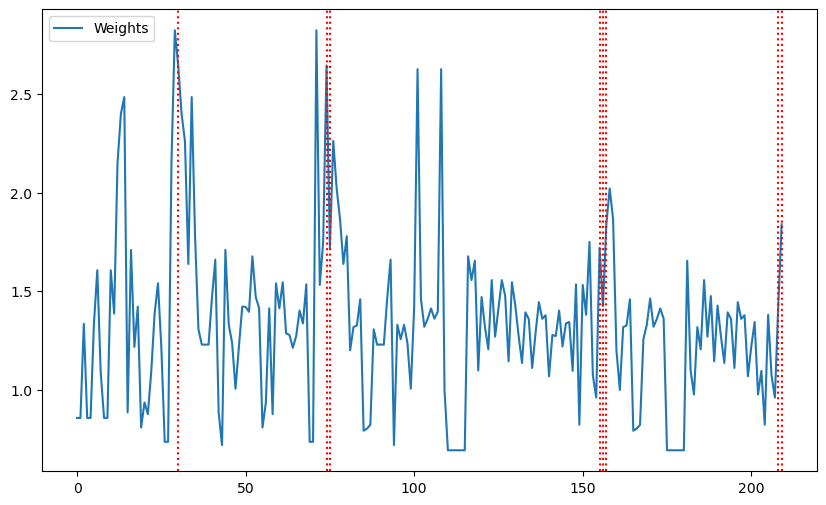

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(weights, label='Weights')

# Plotting the ground truth edges as vertical dotted lines
for i in range(len(edge_gt)):
    if edge_gt[i] == 1:
        plt.axvline(x=i, color='r', linestyle='dotted')

plt.legend()
plt.show()

Compute AUC on the whole dataset

In [51]:
dataset.targets[0]

1.0

In [54]:
node_states[0].shape

torch.Size([106, 256])

In [14]:
from torch_sparse import SparseTensor
from sklearn.decomposition import PCA
from einops import rearrange
from sklearn.metrics import roc_auc_score

from DMD.sindy import sindy_library_adj, sindy_fit2
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt = ground_truth("facebook_ct1")
aucs = []

for idx in range(len(edge_indexes)):
    
    if dataset.targets[idx] == 0:
        continue

    # Build adj matrix
    edge_index = torch.cat(edge_indexes[idx], dim=1)
    edge_index = torch.unique(edge_index.T, dim=0).T

    num_nodes = edge_index.max().item() + 1
    adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adj_matrix = adj_matrix.to_dense()

    # Reduce the dimensionality of the node states 
    node_states_i = rearrange(node_states[idx], 't n f -> n t f')
    pca = PCA(n_components=10)
    X = pca.fit_transform(rearrange(node_states_i, 'n t f -> (n t) f'))
    X = rearrange(X, '(n t) f -> n t f', n=num_nodes, t=node_states_i.shape[1], f=10)
    X = torch.from_numpy(X)

    # Apply SINDy
    s = sindy_library_adj(X, adj_matrix)
    x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
    y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')
    K = sindy_fit2(x, y, 1.0)

    # Remove "F" dimension
    num_blocks = K.shape[0] // 10
    sum_K = np.array([np.sum(K[i*10:(i+1)*10], axis=0) for i in range(num_blocks)])
    num_blocks = K.shape[1] // 10
    sum_K = np.stack([np.sum(sum_K[:,i*10:(i+1)*10], axis=1) for i in range(num_blocks)], axis=1)

    # Compute the weights
    weights = np.abs(sum_K[:,2*num_nodes:]).sum(axis=0)

    # Ground truth
    edge_gt = torch.zeros(edge_index.size(1), dtype=torch.int)
    for i in range(edge_index.size(1)):
        src, tgt = edge_index[0, i], edge_index[1, i]
        if src in torch.where(nodes_gt[idx][-1])[0] and tgt in torch.where(nodes_gt[idx][-1])[0]:
            edge_gt[i] = 1
    
    # Compute the AUC score
    if torch.sum(edge_gt) == 0:
        print("No ground truth edges: ", idx)
        continue
    auc_score = roc_auc_score(edge_gt, weights)
    aucs.append(auc_score)

aucs = np.array(aucs)

995it [00:07, 134.08it/s]


No ground truth edges:  50
No ground truth edges:  180
No ground truth edges:  184
No ground truth edges:  202
No ground truth edges:  206
No ground truth edges:  232
No ground truth edges:  236
No ground truth edges:  264
No ground truth edges:  276
No ground truth edges:  284
No ground truth edges:  294
No ground truth edges:  302
No ground truth edges:  486
No ground truth edges:  500
No ground truth edges:  506
No ground truth edges:  508
No ground truth edges:  524
No ground truth edges:  564
No ground truth edges:  574
No ground truth edges:  576
No ground truth edges:  660
No ground truth edges:  682
No ground truth edges:  686
No ground truth edges:  734
No ground truth edges:  754
No ground truth edges:  826
No ground truth edges:  830
No ground truth edges:  838
No ground truth edges:  858
No ground truth edges:  868
No ground truth edges:  872
No ground truth edges:  908
No ground truth edges:  926
No ground truth edges:  958
No ground truth edges:  980
No ground truth edges

In [15]:
aucs.mean()

0.5947352095123158

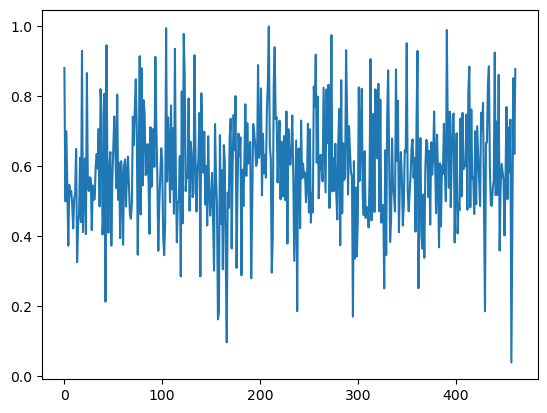

In [18]:
plt.plot(aucs)

Taking each components of the "F" dimension separately

In [ ]:
from DMD.dmd import KANN

dim_red = 10
method = 'PCA'

# compute local Koopman operator
kann_ = KANN(node_states, k=dim_red, emb=method)

K0 = kann_.compute_KOP()
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

vr = V.real

# Calculate the projection
nodes_red = kann_.emb_engine.transform(rearrange(node_states, 'n t f -> (n t) f'))
nodes_red = rearrange(nodes_red, '(n t) f -> n t f', n = node_states.shape[0], t=node_states.shape[1], f=dim_red)
nodes_proj = np.dot(nodes_red, vr)

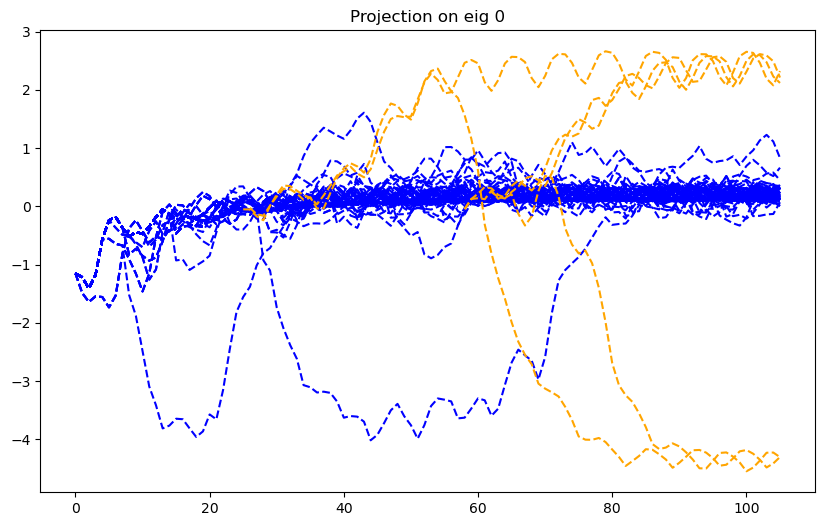

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

node_y = node_labels[0][:,:,0].numpy().T

i=0

val_proj = nodes_proj[:,:,i]

m = np.where(node_y.astype(bool), val_proj, np.NaN)
m_not = np.where(~node_y.astype(bool), val_proj, np.NaN)
# m_gt = np.where((nodes_gt[0].T != 0).numpy().astype(bool), val_proj, np.NaN)

for l in range(m_not.shape[0]):
    axs.plot(m_not[l], c='b', label="class 0", linestyle='dashed')
for n in range(m.shape[0]):
    axs.plot(m[n], c='orange', label="class 1", linestyle='dashed')
# for k in range(m_gt.shape[0]):
#     axs.plot(m_gt[k], c='r', label="GT", linestyle='dotted')
axs.set_title(f'Projection on eig {i}')

# idx_t = np.where(times_gt[0] != 0)[0]
# for j in idx_t:
#     axs.axvline(x=j, color='b', linestyle='dotted')
    
# Show the plot
plt.show()

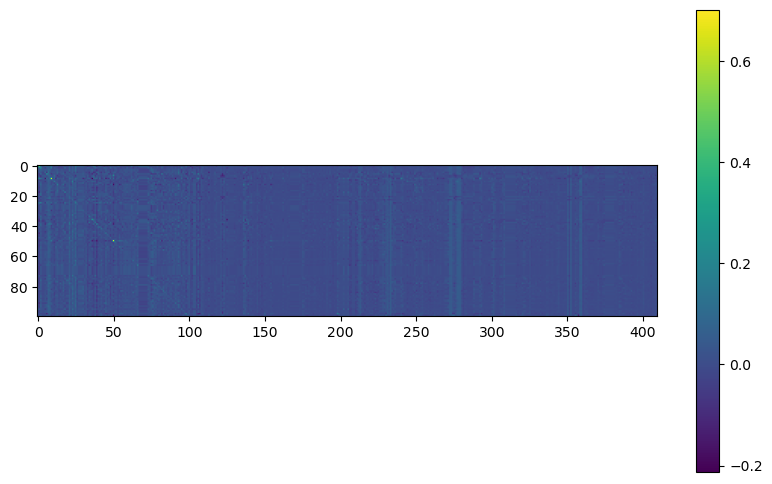

In [ ]:
nodes_proj0 = nodes_proj[:,:,0]
nodes_proj0 = nodes_proj0[:,:,np.newaxis]

s0 = sindy_library_adj(torch.from_numpy(nodes_proj0), adj_matrix)

x0 = rearrange(s0[:,:-1,:], 'n t f -> t (n f)')
y0 = rearrange(s0[:num_nodes,1:,:], 'n t f -> t (n f)')

K_F = sindy_fit2(x0, y0, 1.0)

plt.figure(figsize=(10, 6))
plt.imshow(K_F)
plt.colorbar()
plt.show()

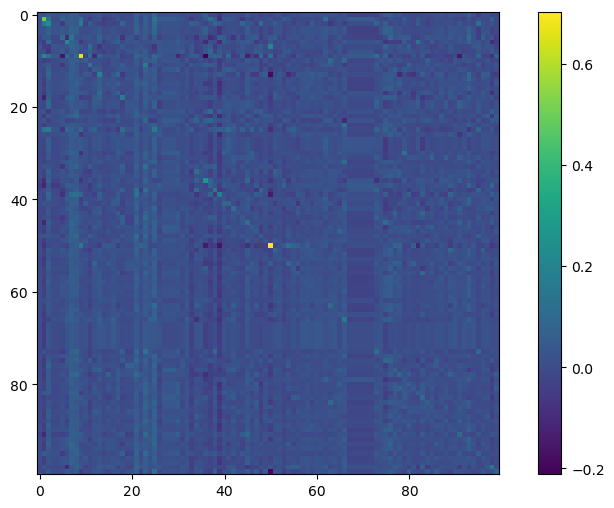

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,:100])
plt.colorbar()
plt.show()

In [ ]:
np.where(np.abs(K_F[:,:100].sum(axis=0))>2.5)

(array([ 2,  7,  8, 13, 21, 23, 25, 39, 45, 66, 93]),)

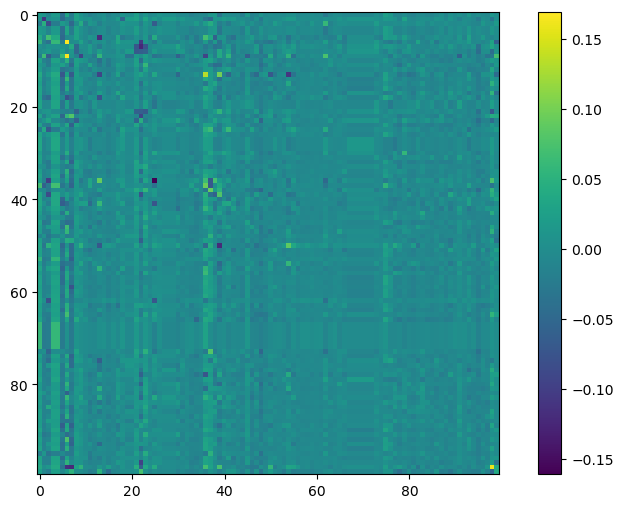

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,100:200])
plt.colorbar()
plt.show()

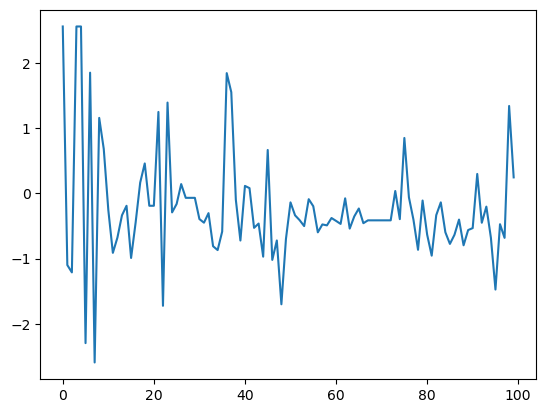

In [ ]:
plt.plot(K_F[:,100:200].sum(axis=0))

In [ ]:
np.where(np.abs(K_F[:,100:200].sum(axis=0))>1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 21, 22, 23, 36, 37, 46, 48, 95,
        98]),)

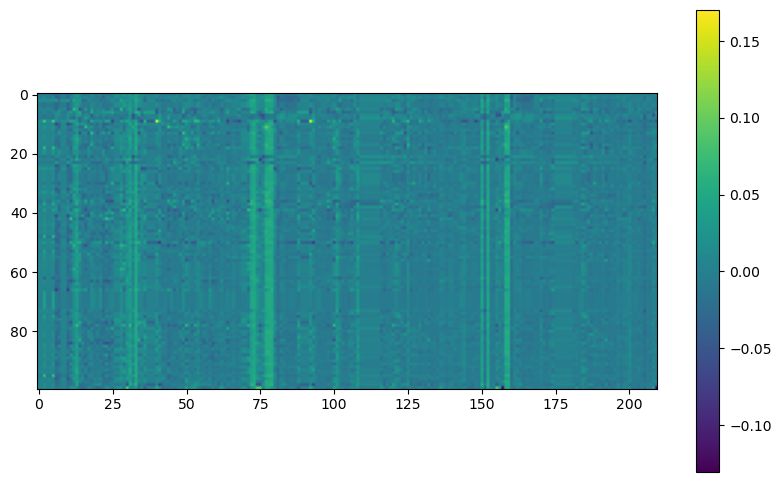

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(K_F[:,200:])
plt.colorbar()
plt.show()

In [ ]:
# c_idx = 0

# num_blocks = K.shape[0] // 10
# K_F = np.array([K[i*10 + c_idx] for i in range(num_blocks)])

# num_blocks = K.shape[1] // 10
# K_F = np.stack([K_F[:,i*10 + c_idx] for i in range(num_blocks)], axis=1)

# plt.figure(figsize=(10, 6))
# plt.imshow(K_F)
# plt.colorbar()
# plt.show()

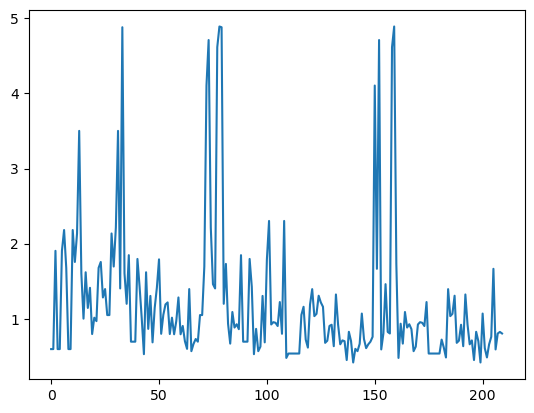

In [ ]:
weights = np.abs(K_F[:,200:]).sum(axis=0)

plt.plot(weights)

/tmp/ipykernel_900266/3796056804.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)


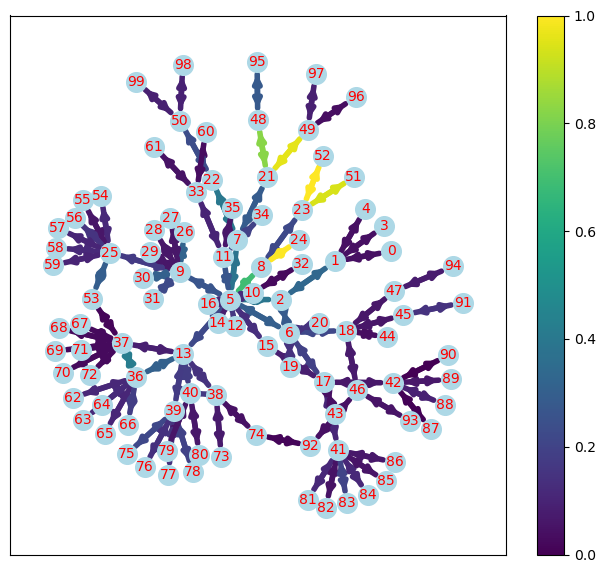

In [ ]:
# Create an empty graph
plt.figure(figsize=(8, 7))
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(num_nodes))
n_labels = {i: str(i) for i in range(num_nodes)}

# Add edges
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')
norm = plt.Normalize(min(weights), max(weights))
colors = [cmap(norm(w)) for w in weights]
# im = nx.draw(G, pos=pos, node_color='lightblue', edge_color=colors, width=2)
pax = nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)
nx.draw_networkx_labels(G, pos, n_labels, font_size=10,font_color='r')

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
# sm._A = []
plt.colorbar(pax)

# Show the plot
plt.show()

In [ ]:
# E, V = np.linalg.eig(K)

# # sort eigenvalues and eigenvectors
# idx = np.argsort(np.abs(E))[::-1]
# E = E[idx]
# V = V[:, idx]

# cmap = matplotlib.colormaps.get_cmap('viridis')

# plt.figure(figsize=(5,5))
# plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
# circle = plt.Circle((0, 0), 1, color='r', fill=False)
# plt.gca().add_patch(circle)
# plt.ylabel('Imaginary') 
# plt.xlabel('Real')
# plt.show()

In [ ]:
# (np.abs(E)>0.9).sum()

98